In [176]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

plt.style.use("seaborn-v0_8")
random_state = 42

# Unsupervised Learning
- Given a set of variables, the goal is to discover interesting things about them: there is no output variable to predict.


---
---
## Anomaly Detection
- Identification of rare samples which deviate significantly from the majority of the data and/or do not follow a well-defined notion of normal behavior
- In an Unsupervised Approach the samples are not labeled, therefore the goal is to discover dissimilarities among them


---
### &rarr; (Unsupervised) k-Nearest Neighbour
- Given $k$ number of neighbors, $D$ distance threshold. Check every sample $X$ of the dataset. Let $N_X$ be the number of $D$-distance neighbors of $X$. If $N_X < k$ (if a sample has an insufficient number of neighbors) then mark the sample as anomalous, otherwise mark it as normal.

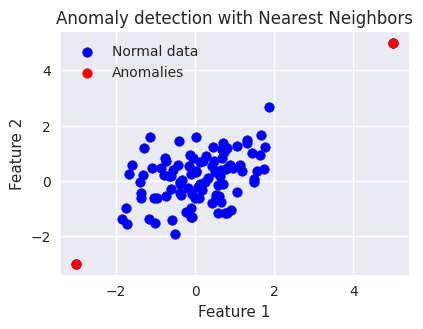

In [177]:
# Generate casual data with two anomalies
np.random.seed(random_state)
normal_data = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], 100)
data = np.vstack((normal_data, [[5, 5], [-3, -3]]))

model = NearestNeighbors(n_neighbors=5)
model.fit(data)

# Find the nearest neighbors for all points
distances, indices = model.kneighbors(data)

# Identify the indices of anomalies points
anomaly_distance = 2
anomaly_indices = np.where(distances[:, -1] > anomaly_distance)[0]

plt.figure(figsize=(4, 3))
plt.scatter(data[:, 0], data[:, 1], color="blue", label="Normal data")
plt.scatter(
    data[anomaly_indices, 0], data[anomaly_indices, 1], color="red", label="Anomalies"
)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Anomaly detection with Nearest Neighbors")
plt.legend()
plt.grid(True)
plt.show()

---
---
## Clustering Methods
-  The goal is to partition the samples of a dataset into distinct groups so that the samples within each group are quite similar to each other, while samples in different groups are quite different from each other.
- In general, clustering is an NP-complete problem, which means that the optimal solution cannot be found without trying all combinations of points and clusters.

### Metrics [(doc)](https://scikit-learn.org/stable/modules/classes.html#clustering-metrics)
| | |
| --- | --- | 
| **Inertia** or **Within-Cluster Variation** | - Is the sum of squared distances of samples to their closest cluster center. <br> - Ranges from 0 with no upper limit. The optimal is 0 |
| **Silhouette Coefficient** | - Is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors: 1) How close the data point is to other points in the cluster; 2) How far away the data point is from points in other clusters <br> - Ranges between -1 (low cohesion, or, in other words, with high sparsity) and +1 (when clusters are dense and well separated). Scores around zero indicate overlapping clusters. <br> - For a set of samples it's the average of the Silhouette Coefficient for each sample. When the score is less than zero for an object it means that there is a dominance of objects in other clusters at a distance smaller than objects of the same cluster |
| **Calinski-Harabaz Index** | - Given the knowledge of the *ground truth* class assignments (labels_true), and the *assignments* of the same samples (labels_pred) from the clustering algorithm, the Calinski-Harabaz Index is calculated using the between-cluster dispersion and within-cluster dispersion in order to measure the distinctiveness between groups. <br>- Has no bound. Is higher when clusters are dense and well separated |
| **Davies-Bouldin Index** | - Given the knowledge of the *ground truth* class assignments (labels_true), and the *assignments* of the same samples (labels_pred) from the clustering algorithm, this index signifies the average 'similarity' between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. <br>- Only has 0 as low bound. Values closer to zero indicate a better partition |
| **Adjusted Rand Index (ARI)** | - Given the knowledge of the *ground truth* class assignments (labels_true), and the *assignments* of the same samples (labels_pred) from the clustering algorithm, the Adjusted Rand Index is a function that measures the similarity of the two. <br>- Ranges between -1 (poorly agreeing labels) and +1 (perfectly labeled clusters). A score close to 0.0 indicates random assignments|
| **Adjusted Mutual Information (AMI)** | - Given the knowledge of the *ground truth* class assignments (labels_true), and the *assignments* of the same samples (labels_pred) from the clustering algorithm, the Adjusted Mutual Information is a function that measures the agreement of the two. <br>- Ranges between -1 (poorly agreeing labels) and +1 (perfectly labeled clusters). Random (uniform) label assignments have a AMI score close to 0.0 |

---
### &rarr; K-Means
- K-means aims to partition a set of observations into $K$ clusters, where each observation belongs to the cluster with the nearest mean (cluster center or *centroid*). The centroids serve as prototypes for the clusters.
- The number of clusters $K$ must be provided as input.
- K-means tries to minimize the ***Within-Cluster Variation*** or ***Inertia*** or ***Sum-of-squares Criterion*** (squared Euclidean distances), defined as the amount by which the observations belonging to a cluster differ from each other. It's an optimization problem: $$ \min_{C_1, C_2, \ldots, C_K} \left\{\sum_{i=1}^{K} \frac{1}{|C|} \sum_{j,l \in C_i} \sum_{m=1}^p (X_{j,m} - X_{l,m})^2\right\}$$
- Although the problem is NP-hard, efficient heuristic algorithms (such as Lloyd’s or Elkan’s) converge quickly to a local optimum.
- Process:
    - Randomly assign each observation of the dataset to one of the $K$ clusters.
    - At each iteration:
        - Compute the *centroid* of each cluster 
        - Assign each data point to the nearest centroid (typically based on Euclidean distance)
        - Recalculate the centroids by taking the mean of the data points assigned to each cluster.
        - Repeat the iteration until convergence (when centroids no longer change significantly), or until reached a maximum number of iterations or until the total clustering error is below a given threshold
- It is very sensitive to outliers: apply Min-Max Scaling or Standardization to cope with outliers and different value ranges.
- Does not deal with noise and does not deal properly with non convex clusters
- It suffers a lot from high dimensional data
- To choose the correct number of clusters $K$: repeate the computation from $K=1$ until the *Within-Cluster Variation* is pretty constant ("elbow method")
- Run multiple times and choose the solution with minimal *WCV* to cope with the randomness caused by the initial allocation of samples

#### METRIC: Inertia (Within-Cluster Variation)

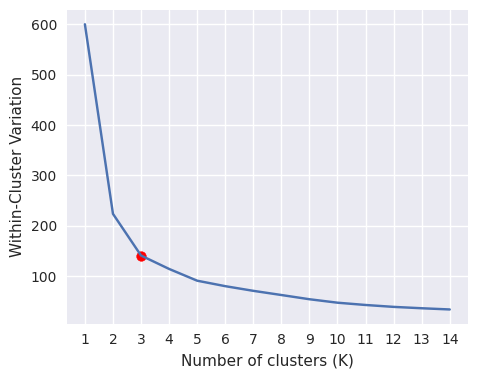

In [178]:
from kneed import KneeLocator

# Standard data
df = pd.read_csv("datasets/iris.data.txt")
df.drop("Class", axis=1, inplace=True)
df = preprocessing.StandardScaler().fit_transform(df)

# Cycle on cluster number
wcv = []
cluster_range = range(1, 15)
for k in cluster_range:
    kmeans = KMeans(
        n_clusters=k,
        n_init=100,
        random_state=random_state,
    )
    kmeans.fit(df)
    wcv.append(kmeans.inertia_)


# Best cluster number
kl = KneeLocator(cluster_range, wcv, curve="convex", direction="decreasing").elbow

# Plot
plt.figure(figsize=(5, 4))
plt.plot(cluster_range, wcv)
plt.scatter(kl, wcv[kl - 1], c="r")
plt.xticks(cluster_range)
plt.xlabel("Number of clusters (K)"), plt.ylabel("Within-Cluster Variation")
plt.tight_layout()
plt.show()

#### METRIC: Silhouette Coefficient

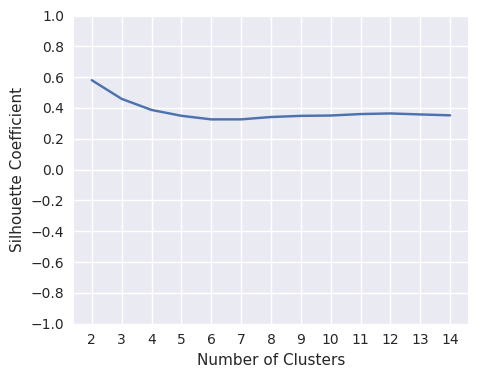

In [180]:
from sklearn.metrics import silhouette_score

silhouette_coefficients = []
cluster_range = range(2, 15)  # must be at least 2 clusters
for k in cluster_range:
    kmeans = KMeans(
        n_clusters=k,
        n_init=100,
        random_state=random_state,
    )
    kmeans.fit(df)

    score = silhouette_score(df, kmeans.labels_)
    silhouette_coefficients.append(score)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(cluster_range, silhouette_coefficients)
plt.xticks(cluster_range), plt.yticks(np.arange(-1, 1.2, 0.2))
plt.xlabel("Number of Clusters"), plt.ylabel("Silhouette Coefficient")
plt.tight_layout()
plt.show()

#### METRIC: Calinski-Harabasz Index

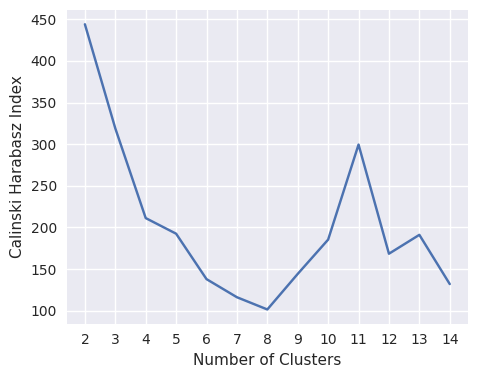

In [181]:
from sklearn.metrics import calinski_harabasz_score

ground_truth = LabelEncoder().fit_transform(
    pd.read_csv("datasets/iris.data.txt")["Class"]
)

coefficients = []
cluster_range = range(2, 15)  # must be at least 2 clusters
for k in cluster_range:
    kmeans = KMeans(
        n_clusters=k,
        n_init=100,
        random_state=random_state,
    )
    kmeans.fit(df)

    score = calinski_harabasz_score(ground_truth.reshape(-1, 1), kmeans.labels_)
    coefficients.append(score)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(cluster_range, coefficients)
plt.xticks(cluster_range)
plt.xlabel("Number of Clusters"), plt.ylabel("Calinski Harabasz Index")
plt.tight_layout()
plt.show()

#### METRIC: Davies-Bouldin Index

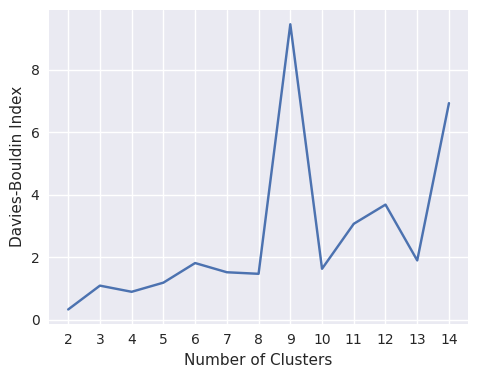

In [182]:
from sklearn.metrics import davies_bouldin_score


coefficients = []
cluster_range = range(2, 15)  # must be at least 2 clusters
for k in cluster_range:
    kmeans = KMeans(
        n_clusters=k,
        n_init=100,
        random_state=random_state,
    )
    kmeans.fit(df)

    score = davies_bouldin_score(ground_truth.reshape(-1, 1), kmeans.labels_)
    coefficients.append(score)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(cluster_range, coefficients)
plt.xticks(cluster_range)
plt.xlabel("Number of Clusters"), plt.ylabel("Davies-Bouldin Index")
plt.tight_layout()
plt.show()

#### METRIC: Adjusted Rand Index

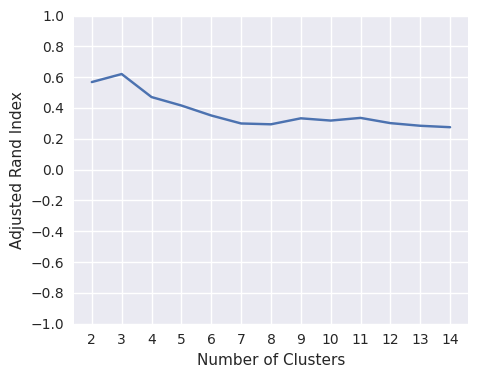

In [183]:
from sklearn.metrics import adjusted_rand_score

coefficients = []
cluster_range = range(2, 15)  # must be at least 2 clusters
for k in cluster_range:
    kmeans = KMeans(
        n_clusters=k,
        n_init=100,
        random_state=random_state,
    )
    kmeans.fit(df)

    score = adjusted_rand_score(ground_truth, kmeans.labels_)
    coefficients.append(score)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(cluster_range, coefficients)
plt.xticks(cluster_range), plt.yticks(np.arange(-1, 1.2, 0.2))
plt.xlabel("Number of Clusters"), plt.ylabel("Adjusted Rand Index")
plt.tight_layout()
plt.show()

#### METRIC: Adjusted Mutual Information

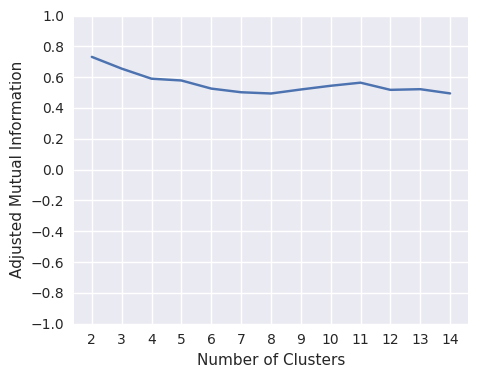

In [184]:
from sklearn.metrics import adjusted_mutual_info_score

coefficients = []
cluster_range = range(2, 15)  # must be at least 2 clusters
for k in cluster_range:
    kmeans = KMeans(
        n_clusters=k,
        n_init=100,
        random_state=random_state,
    )
    kmeans.fit(df)

    score = adjusted_mutual_info_score(ground_truth, kmeans.labels_)
    coefficients.append(score)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(cluster_range, coefficients)
plt.xticks(cluster_range), plt.yticks(np.arange(-1, 1.2, 0.2))
plt.xlabel("Number of Clusters"), plt.ylabel("Adjusted Mutual Information")
plt.tight_layout()
plt.show()

---
### &rarr; Gaussian Mixture Model (GMM)
- It is a probabilistic model that represents a mixture of several Gaussian distributions. It assumes that the data is generated from a combination of multiple Gaussian components. Each component in the mixture corresponds to a cluster within the data.
- The model parameters include:
    - Means (average values) for each Gaussian component.
    - Variances (spread) for each component.
    - Mixing coefficients that determine the contribution of each component to the overall distribution.
- *Expectation-Maximization* (EM) algorithm is commonly used to estimate these parameters from the data:
    - At first it randomly initializes the model parameters
    - At each iteration:
        - Expectation step (E-step): for each observation, find the weights that encode the probability of membership to each cluster (means)
        - Maximization step (M-step): for each cluster, update the model parameters to maximize the likelihood of the observed data (variances and mixing coefficients)
        - Repeat the iteration until the model converges to a local maximum of the likelihood function.

In [188]:
df = pd.read_csv("datasets/iris.data.txt")
df.drop("Class", axis=1, inplace=True)

gmm = GaussianMixture(
    n_components=3,
    init_params="k-means++",
    max_iter=300,
    n_init=10,
    random_state=random_state,
)

gmm.fit(df)

GaussianMixture(init_params='k-means++', max_iter=300, n_components=3,
                n_init=10, random_state=42)

---
### &rarr; DBSCAN
- Density-Based Spatial Clustering of Applications with Noise
- It doesn't require specifying the $K$ number of clusters beforehand. Instead, it relies on two key parameters: **eps** (maximum distance between data points in the same neighborhood) and **min_samples** (minimum number of data points to form a cluster).
- It identifies clusters based on the density of data points.
-  It assigns one of the following three categories to each sample:
    - Core Points: Data points within a dense region (have at least min_samples neighbors within distance eps).
    - Border Points: Data points on the edge of a cluster (have fewer than min_samples neighbors but are within eps distance from a core point).
    - Noise Points: Isolated data points (not part of any cluster).
- It forms clusters by connecting core points and border points.

In [186]:
df = pd.read_csv("datasets/iris.data.txt")
df_X = df.iloc[:, 0:4]
encoder = LabelEncoder()
df_y = encoder.fit_transform(df["Class"])

# df = pd.read_csv("datasets/marketing_campaign.csv", sep=";").dropna()
# df_X = pd.get_dummies(df.iloc[:, :-1].drop("Dt_Customer", axis=1))
# df_y = df.iloc[:, -1]

clustering = DBSCAN(eps=1, min_samples=4, n_jobs=-1)

y_pred = clustering.fit_predict(df_X)
print(f"Accuracy: {cluster_acc(df_y, y_pred):.4f}")

Accuracy: 0.6667


---
### &rarr; Agglomerative Clustering
- Produce a dendrogram (tree-based representation of the observations). Leafs of the dendrogram are the observations of the dataset. Root of the dendrogram is the parent cluster corresponding to the dataset. One single dendrogram can be used to obtain an arbitrary number of clusters, by simply adding a horizontal cut to the dendrogram.
- Need to give as input a measure of dissimilarity
- Process:
    - Initialize each observation as its own cluster
    - At each iteration:
        - Compute dissimilarity values among all couples of clusters.
        - Merge the two clusters with minimal dissimilarity.
        - Dissimilarity between these two clusters indicates the height in the dendrogram at which the fusion should be placed.
        - Stop iterating when no fusions are possible

Accuracy: 0.8933


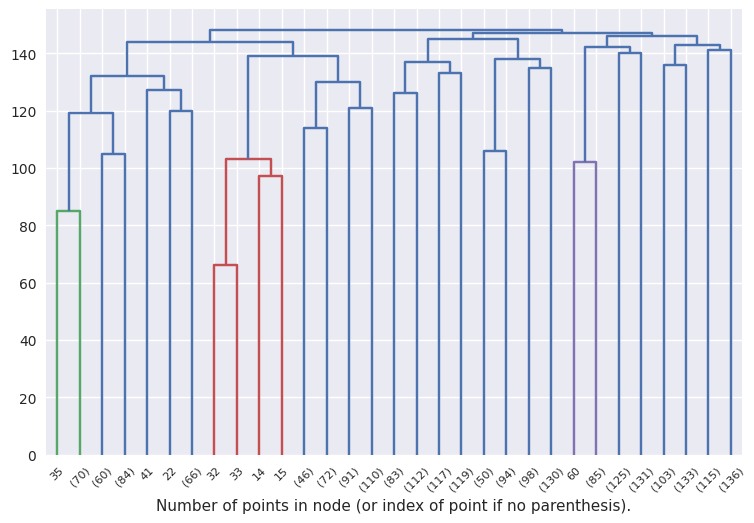

In [187]:
df = pd.read_csv("datasets/iris.data.txt")
df_X = df.iloc[:, 0:4]
encoder = LabelEncoder()
df_y = encoder.fit_transform(df["Class"])

# df = pd.read_csv("datasets/marketing_campaign.csv", sep=";").dropna()
# df_X = pd.get_dummies(df.iloc[:, :-1].drop("Dt_Customer", axis=1))
# df_y = df.iloc[:, -1]

clustering = AgglomerativeClustering(
    n_clusters=3
    # n_clusters=None,
    # distance_threshold=0,
    # compute_full_tree=True,
)
y_pred = clustering.fit_predict(df_X)
print(f"Accuracy: {cluster_acc(df_y, y_pred):.4f}")


# Plotting the dendogram (4 levels)
def plot_dendrogram(model, **kwargs):
    children = model.children_
    distance = np.arange(children.shape[0])
    no_of_observations = np.arange(2, children.shape[0] + 2)
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(
        float
    )
    dendrogram(linkage_matrix, **kwargs)


plot_dendrogram(clustering, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()